## Importing required (obviously) packages

In [1]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Dropout
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Model

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input



from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

Using TensorFlow backend.
C:\Users\Saranga\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Saranga\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Saranga\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Saranga\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [2]:
dataset='dataset'

### Loading images from the dataset and preprocessing

In [3]:
imgpaths=list(paths.list_images(dataset))
len(imgpaths)

4088

In [4]:
data=[]
labels=[]

In [5]:
for img in tqdm(imgpaths):
    label=img.split(os.path.sep)[1]
    
    #loading images and resizing
    image=load_img(img, target_size=(224,224))
    image=img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    labels.append(label)

 84%|█████████████████████████████████████████████████████████████████▏            | 3416/4088 [01:37<01:07,  9.99it/s]C:\Users\Saranga\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████████████████████████████████████████████████████████████████████████| 4088/4088 [02:27<00:00, 27.64it/s]


In [6]:
#convert data and labels lists to numpy arrays
data=np.array(data)
labels=np.array(labels)

In [7]:
#One-hot encoding labels
from sklearn.preprocessing import LabelBinarizer as LB

lb = LB()
labels = lb.fit_transform(labels)

In [8]:
labels = to_categorical(labels)
labels.shape

(4088, 2)

In [9]:
labels[4087]

array([1., 0.], dtype=float32)

In [10]:
labels[0]

array([0., 1.], dtype=float32)

## Spliiting data into train and test sets

In [11]:
from sklearn.model_selection import train_test_split as TTS

(X_train, X_test, y_train, y_test)=TTS(data,labels,test_size=0.2, random_state=7)

## Data Augmentation

In [12]:
aug=ImageDataGenerator(
    rotation_range=12,
    zoom_range=7,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'   
)

## Transfer learning (VGG19)

In [13]:
base_model = VGG19(weights="imagenet", include_top=False, input_tensor=(Input(shape=(224,224,3))))

In [14]:
head_model=base_model.output
head_model=Flatten()(head_model)
head_model=Dense(128, activation='relu')(head_model)
head_model=Dropout(0.3)(head_model)
head_model=Dense(2,activation='softmax')(head_model)

In [15]:
model=Model(inputs=base_model.input, outputs=head_model)

In [16]:
for layer in base_model.layers:
    layer.trainable=False
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [21]:
optimizer=Adam(lr=0.0001)
epochs=10
batch_size=16

In [22]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [23]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(3270, 224, 224, 3)
(3270, 2)
(818, 224, 224, 3)
(818, 2)


In [24]:
history=model.fit(
    aug.flow(X_train, y_train, batch_size=batch_size), 
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=(X_test,y_test),
    epochs=epochs
        )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
204/204 [==============================] - 223s 1s/step - loss: 1.8616 - accuracy: 0.7523 - val_loss: 0.2005 - val_accuracy: 0.9694
Epoch 2/10
204/204 [==============================] - 274s 1s/step - loss: 0.5162 - accuracy: 0.8294 - val_loss: 0.2189 - val_accuracy: 0.9560
Epoch 3/10
204/204 [==============================] - 285s 1s/step - loss: 0.3843 - accuracy: 0.8417 - val_loss: 0.1607 - val_accuracy: 0.9694
Epoch 4/10
204/204 [==============================] - 307s 2s/step - loss: 0.3278 - accuracy: 0.8703 - val_loss: 0.0862 - val_accuracy: 0.9780
Epoch 5/10
204/204 [==============================] - 325s 2s/step - loss: 0.3010 - accuracy: 0.8771 - val_loss: 0.1013 - val_accuracy: 0.9768
Epoch 6/10
204/204 [==============================] - 314s 2s/step - loss: 0.3113 - accuracy: 0.8798 - val_loss: 0.1180 - val_accuracy: 0.9743
Epoch 7/10
204/204 [===========================

In [25]:
preds=model.predict(X_test, batch_size=batch_size)

In [26]:
outputs=np.argmax(preds, axis=1)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), outputs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       432
without_mask       0.98      0.98      0.98       386

    accuracy                           0.98       818
   macro avg       0.98      0.98      0.98       818
weighted avg       0.98      0.98      0.98       818



### Got an amazing result, hence storing the model

In [28]:
model.save('model.h5')

In [29]:
from keras.models import load_model


x=load_model('model.h5')

In [30]:
preds=x.predict(X_test, batch_size=batch_size)
x_outputs=np.argmax(preds, axis=1)
y=x_outputs-outputs

## Visualizing training and validation accuracy and loss

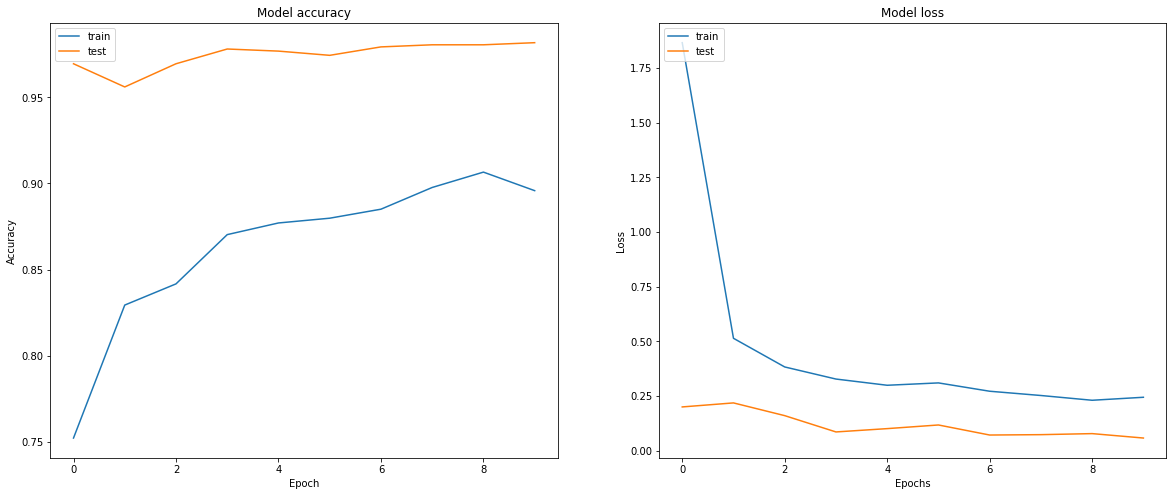

In [31]:
plt.figure(figsize=(20,8))

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig('Model_training_history.png')